In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression 


In [29]:
session = "Pilot5"
data_dir = f"/Users/thenning/Documents/GitHub/neurobubbles/Data/{session}"
order_data = pd.read_csv((glob.glob(f"{data_dir}/orders*.csv"))[0])
round_data = pd.read_csv((glob.glob(f"{data_dir}/rounds*.csv"))[0])
payments_data = pd.read_csv((glob.glob(f"{data_dir}/payment*.csv"))[0])
prescreen_data = pd.read_csv((glob.glob(f"{data_dir}/prescreen*.csv"))[0])
pagetime_data = pd.read_csv((glob.glob(f"{data_dir}/PageTimes*.csv"))[0])


# Price Data

In [30]:
def basic_price_data(order_data):
    sell_orders = []
    min_sell_price = []
    buy_orders = []
    max_buy_price = []
    market_price = []
    volume = []
    for round in np.unique(order_data['round_number']):
        df = order_data[order_data['round_number']== round]
        sell_orders.append(np.sum(df[df['type'] == 'SELL']['quantity']))
        min_sell_price.append(np.min(df[df['type'] == 'SELL']['price']))
        buy_orders.append(np.sum(df[df['type'] == 'BUY']['quantity']))
        max_buy_price.append(np.max(df[df['type'] == 'BUY']['price']))
        market_price.append(np.unique(df['market_price']))
        volume.append(np.unique(df['volume']))


    #turning into numpy arrays cause its nice
    sell_orders_array = np.array(sell_orders)
    min_sell_price_array = np.array(min_sell_price)
    buy_orders_array = np.array(buy_orders)
    max_buy_price_array = np.array(max_buy_price)
    market_price_array = np.array(market_price)
    volume_array = np.array(volume)
    return sell_orders_array, min_sell_price_array, buy_orders_array, max_buy_price_array,market_price_array, volume_array

sell_orders_array, min_sell_price_array, buy_orders_array, max_buy_price_array,market_price_array, volume_array = basic_price_data(order_data)

# Risk Adjusted Moving Average

In [31]:
def get_round_risk_adjusted(round_data):
    risk_adjusted_score=[]
    for i in np.unique(round_data['subsession.round_number']):
        if i <= 3:
            risk_adjusted_score.append(None)
        else:
            r1 = round_data[round_data['subsession.round_number'] == i]
            risk_adjusted_score.append(np.mean(r1["player.dose_r"]))
    return risk_adjusted_score
risk_adjusted_score = get_round_risk_adjusted(round_data)

def get_risk_adj_mv_avg(round_data, m):
    risk_adjusted_score = get_round_risk_adjusted(round_data)
    mv_avg = []
    for idx, score in enumerate(risk_adjusted_score):
        if idx < 3: # makes sure not in practice
            continue
        else:
            scores = []
            if idx - m < 3: # if moving average would go into practice then cut avg short
                if idx - 3 == 0: #fixes 0 case
                    scores.append(risk_adjusted_score[idx])
                else:
                    for i in range(idx - 3):
                        scores.append(risk_adjusted_score[idx - i])
            else:
                for i in range(idx - m):
                    scores.append(risk_adjusted_score[idx - i])
            mv_avg.append(np.mean(scores))
    return mv_avg

risk_adjusted_score = get_risk_adj_mv_avg(round_data, 3)

# Forecast Error

Text(0.5, 1.0, 'Forecast Error 10-period')

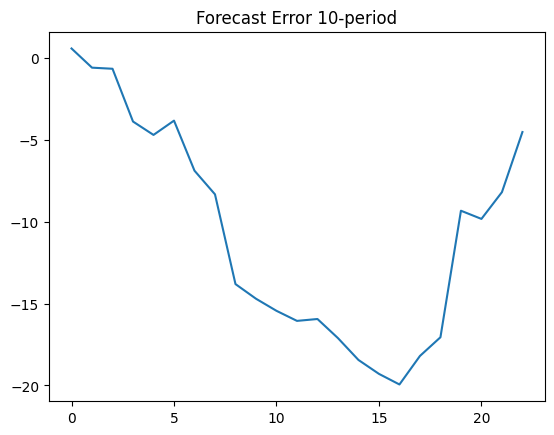

In [32]:
def get_forecast_data(round_data):
    f1mean_forecast=[]
    f2mean_forecast=[]
    f3mean_forecast=[]
    f4mean_forecast=[]
    for i in np.unique(round_data['subsession.round_number']):
        r1 = round_data[round_data['subsession.round_number'] == i]
        f1mean_forecast.append(np.mean(r1['player.f0']))
        f2mean_forecast.append(np.mean(r1['player.f1']))
        f3mean_forecast.append(np.mean(r1['player.f2']))
        f4mean_forecast.append(np.mean(r1['player.f3']))
    return [f1mean_forecast, f2mean_forecast, f3mean_forecast, f4mean_forecast]

def forecast_error(round_data,market_price_array, t, m):
    forecasts = get_forecast_data(round_data)
    if m == 0:
        forecast_array = forecasts[0]
    elif m == 2:
        forecast_array = forecasts[1]
    elif m == 5:
        forecast_array = forecasts[2]
    elif m == 10:
        forecast_array = forecasts[3]

    forecast_error = forecast_array[t-m] - market_price_array[t]
    return forecast_error[0]

def generate_forecast_error(round_data, market_price_array, m):
    forecast_error_array = []
    for t, price in enumerate(market_price_array):
        if t < m:
            error = None
        else:
            error = forecast_error(round_data, market_price_array, t, m)
        forecast_error_array.append(error)
    return forecast_error_array

m = 10
errors = generate_forecast_error(round_data, market_price_array, m)
plt.plot(errors[m:])
plt.title(f"Forecast Error {m}-period")


# Orderbook Pressure

In [33]:
def get_orderbook_pressure_per_round(order_data, t):
    round_data = order_data[order_data['round_number']== t]
    market_price = np.unique(round_data['market_price'])[0]

    buy_d = round_data[round_data['type'] =='BUY']
    max_unfilled_bid = np.max(buy_d[buy_d['price'] <market_price]['price'])
    bid_quantity = np.sum(buy_d[buy_d['price'] ==max_unfilled_bid]['quantity'])

    ask_d = round_data[round_data['type'] =='SELL']
    min_unfilled_ask = np.min(ask_d[ask_d['price'] > market_price]['price'])
    ask_quantity = np.sum(ask_d[ask_d['price'] ==min_unfilled_ask]['quantity'])

    obook_pressure = (max_unfilled_bid * bid_quantity + min_unfilled_ask * ask_quantity)/(bid_quantity+ask_quantity)
    return obook_pressure

def get_order_book_ressure(order_data ):
    order_book_pressure = []
    for round in np.unique(order_data['round_number']):
        order_book_pressure.append(get_orderbook_pressure_per_round(order_data, round))
    return (order_book_pressure)
order_book_pressure = get_order_book_ressure(order_data)

# Asset Allocation

In [34]:
def get_asset_allocation(round_data):
    allocation_list = []
    for i in np.unique(round_data['subsession.round_number']):
        r1 = round_data[round_data['subsession.round_number'] == i]
        cash = np.sum(r1['player.cash'])
        shares = np.sum(r1['player.shares'])
        if i == 4:
            price = 14
        else:
            price = market_price_array[i-2] # -1 since idx starts at 1, -1 for lag
        market_cap = shares * price
        allocation = cash.item() / market_cap.item()
        allocation_list.append(allocation)
    return allocation_list
allocation_list = get_asset_allocation(round_data)
len(allocation_list)

33

# Round Level analysis

In [35]:
round_ml_data = {
    'price': [],
    'volume': [],
    'lag_price': [],
    'lag_volume': [],
    'price_change': [],
    'laged_risk_parameter_mv_avg': [],
    'rounds_remaining': [],
    'order_book_pressure': [],
    'asset_allocation': []
}

# Populate the lists with values for each round
for round in np.unique(order_data['round_number']):
    if round > 3:
        round_ml_data['price'].append(market_price_array[round-1][0])
        round_ml_data['volume'].append(market_price_array[round-1][0])
        if round == 4:
            round_ml_data['price_change'].append(market_price_array[round-1][0] - 14)
            round_ml_data['lag_price'].append(14)
            round_ml_data['lag_volume'].append(None)
            round_ml_data[f'laged_risk_parameter_mv_avg'].append(None)
        else:
            round_ml_data['price_change'].append(market_price_array[round-1][0] - market_price_array[round-2][0])
            round_ml_data['lag_price'].append(market_price_array[round-2][0])
            round_ml_data['lag_volume'].append(volume_array[round-2][0])
            round_ml_data[f'laged_risk_parameter_mv_avg'].append(risk_adjusted_score[round - 3 - 2]) # -3 since it doesn't include practice, -1 since round index starts at 1, -1 for lagged
        round_ml_data['rounds_remaining'].append(33 - round)
        round_ml_data['order_book_pressure'].append(order_book_pressure[round-1])
        round_ml_data['asset_allocation'].append(allocation_list[round-1])

for m in [0,2,5,10]:
    round_ml_data[f'period-{m} forecast error'] = generate_forecast_error(round_data, market_price_array[3:], m)

round_ml_data_df = pd.DataFrame.from_dict(round_ml_data)
round_ml_data_df

,price,volume,lag_price,lag_volume,price_change,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation,period-0 forecast error,period-2 forecast error,period-5 forecast error,period-10 forecast error
0,15.0,15.0,14.0,NaN,1.0,NaN,29,14.375000,1.785714,-2.235294,NaN,NaN,NaN
1,16.0,16.0,15.0,16.0,1.0,0.750691,28,15.645161,1.776667,-2.352941,NaN,NaN,NaN
2,16.0,16.0,16.0,6.0,0.0,0.663946,27,15.600000,1.811406,-1.000000,-1.875000,NaN,NaN
3,17.0,17.0,16.0,5.0,1.0,0.547890,26,16.857143,1.926997,-3.777778,-1.875000,NaN,NaN
4,17.0,17.0,17.0,8.0,0.0,0.585289,25,16.206897,1.963170,-2.722222,-1.166667,NaN,NaN
5,17.0,17.0,17.0,12.0,0.0,0.581501,24,16.416667,2.120147,-2.388889,-2.722222,-1.352941,NaN
6,18.0,18.0,17.0,8.0,1.0,0.604748,23,17.347826,2.249673,-2.777778,-3.111111,1.133333,NaN
7,19.0,19.0,18.0,3.0,1.0,0.638853,22,19.166667,2.286489,-2.777778,-1.777778,-1.166667,NaN
8,20.0,20.0,19.0,9.0,1.0,0.635611,21,20.555556,2.327091,-4.722222,-3.388889,-4.055556,NaN
9,21.0,21.0,20.0,11.0,1.0,0.649507,20,20.476190,2.371264,-4.764706,-4.666667,-3.888889,NaN


In [36]:
def organize_dataorder_data(order_data, market_price_array, risk_adjusted_score, order_book_pressure, allocation_list):
    
    round_ml_data = {
    'price': [],
    'volume': [],
    'lag_price': [],
    'lag_volume': [],
    'price_change': [],
    'laged_risk_parameter_mv_avg': [],
    'rounds_remaining': [],
    'order_book_pressure': [],
    'asset_allocation': []
}

    # Populate the lists with values for each round
    for round in np.unique(order_data['round_number']):
        if round > 3:
            round_ml_data['price'].append(market_price_array[round-1][0])
            round_ml_data['volume'].append(volume_array[round-1][0])
            if round == 4:
                round_ml_data['price_change'].append(market_price_array[round-1][0] - 14)
                round_ml_data['lag_price'].append(14)
                round_ml_data['lag_volume'].append(None)
                round_ml_data[f'laged_risk_parameter_mv_avg'].append(None)
            else:
                round_ml_data['price_change'].append(market_price_array[round-1][0] - market_price_array[round-2][0])
                round_ml_data['lag_price'].append(market_price_array[round-2][0])
                round_ml_data['lag_volume'].append(volume_array[round-2][0])
                round_ml_data[f'laged_risk_parameter_mv_avg'].append(risk_adjusted_score[round - 3 - 2]) # -3 since it doesn't include practice, -1 since round index starts at 1, -1 for lagged
            round_ml_data['rounds_remaining'].append(33 - round)
            round_ml_data['order_book_pressure'].append(order_book_pressure[round-1])
            round_ml_data['asset_allocation'].append(allocation_list[round-1])

    for m in [0,2,5,10]:
        round_ml_data[f'period-{m} forecast error'] = generate_forecast_error(round_data, market_price_array[3:], m)
    round_ml_data_df = pd.DataFrame.from_dict(round_ml_data)
    return round_ml_data_df

In [37]:
round_ml_data_df = organize_dataorder_data(order_data, market_price_array, risk_adjusted_score, order_book_pressure, allocation_list)
#round_ml_data_df.to_csv(fr"/Users/thenning/Documents/GitHub/neurobubbles/Data/Summary_Data/Pilot_5/Panel_Data.csv")
round_ml_data_df

,price,volume,lag_price,lag_volume,price_change,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation,period-0 forecast error,period-2 forecast error,period-5 forecast error,period-10 forecast error
0,15.0,16,14.0,NaN,1.0,NaN,29,14.375000,1.785714,-2.235294,NaN,NaN,NaN
1,16.0,6,15.0,16.0,1.0,0.750691,28,15.645161,1.776667,-2.352941,NaN,NaN,NaN
2,16.0,5,16.0,6.0,0.0,0.663946,27,15.600000,1.811406,-1.000000,-1.875000,NaN,NaN
3,17.0,8,16.0,5.0,1.0,0.547890,26,16.857143,1.926997,-3.777778,-1.875000,NaN,NaN
4,17.0,12,17.0,8.0,0.0,0.585289,25,16.206897,1.963170,-2.722222,-1.166667,NaN,NaN
5,17.0,8,17.0,12.0,0.0,0.581501,24,16.416667,2.120147,-2.388889,-2.722222,-1.352941,NaN
6,18.0,3,17.0,8.0,1.0,0.604748,23,17.347826,2.249673,-2.777778,-3.111111,1.133333,NaN
7,19.0,9,18.0,3.0,1.0,0.638853,22,19.166667,2.286489,-2.777778,-1.777778,-1.166667,NaN
8,20.0,11,19.0,9.0,1.0,0.635611,21,20.555556,2.327091,-4.722222,-3.388889,-4.055556,NaN
9,21.0,8,20.0,11.0,1.0,0.649507,20,20.476190,2.371264,-4.764706,-4.666667,-3.888889,NaN


# ML Model

## Price Prediction

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.svm import SVR 
from sklearn.model_selection import LeaveOneOut, cross_val_score
import matplotlib.pyplot as plt 
import xgboost as xgb

### XgBoost

In [39]:
X, y = round_ml_data_df.drop('price', axis=1), round_ml_data_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

xgb_r.fit(X_train, y_train) 
# Predict the model 
pred = xgb_r.predict(X_test) 

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  2.288236


/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


#### Without Lag price

In [40]:
X, y = round_ml_data_df.drop(['price', 'lag_price'], axis=1), round_ml_data_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

xgb_r.fit(X_train, y_train) 
# Predict the model 
pred = xgb_r.predict(X_test) 

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  3.149829


/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


### Linear Regression

#### Lag Price as Benchmark

In [41]:

X, y = round_ml_data_df['lag_price'], round_ml_data_df[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Instantiation 
xgb_r = xgb.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = 123) 

xgb_r.fit(X_train, y_train) 
# Predict the model 
pred = xgb_r.predict(X_test) 

# RMSE Computation 
rmse = np.sqrt(MSE(y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  2.275297


/Users/thenning/Documents/GitHub/neurobubbles/.venv/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:00:22] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


## SVM

### Linear

In [42]:
round_ml_data_df.fillna(round_ml_data_df.mean())

,price,volume,lag_price,lag_volume,price_change,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation,period-0 forecast error,period-2 forecast error,period-5 forecast error,period-10 forecast error
0,15.0,16,14.0,8.37931,1.0,0.685164,29,14.375000,1.785714,-2.235294,-7.578446,-9.632379,-14.784733
1,16.0,6,15.0,16.00000,1.0,0.750691,28,15.645161,1.776667,-2.352941,-7.578446,-9.632379,-14.784733
2,16.0,5,16.0,6.00000,0.0,0.663946,27,15.600000,1.811406,-1.000000,-1.875000,-9.632379,-14.784733
3,17.0,8,16.0,5.00000,1.0,0.547890,26,16.857143,1.926997,-3.777778,-1.875000,-9.632379,-14.784733
4,17.0,12,17.0,8.00000,0.0,0.585289,25,16.206897,1.963170,-2.722222,-1.166667,-9.632379,-14.784733
5,17.0,8,17.0,12.00000,0.0,0.581501,24,16.416667,2.120147,-2.388889,-2.722222,-1.352941,-14.784733
6,18.0,3,17.0,8.00000,1.0,0.604748,23,17.347826,2.249673,-2.777778,-3.111111,1.133333,-14.784733
7,19.0,9,18.0,3.00000,1.0,0.638853,22,19.166667,2.286489,-2.777778,-1.777778,-1.166667,-14.784733
8,20.0,11,19.0,9.00000,1.0,0.635611,21,20.555556,2.327091,-4.722222,-3.388889,-4.055556,-14.784733
9,21.0,8,20.0,11.00000,1.0,0.649507,20,20.476190,2.371264,-4.764706,-4.666667,-3.888889,-14.784733


# Predicting Positive vs Negative Returns

## DV Generation

In [62]:
return_valence = round_ml_data_df['price_change'].apply(lambda x: 1 if x > 0 else 0).tolist()
sum(return_valence)/len(return_valence)

0.6666666666666666

## XgBoost

In [61]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming round_ml_data_df and return_valence are defined elsewhere

# Splitting the data into features and target variable
X, y = round_ml_data_df.drop(['price', 'price_change'], axis=1), return_valence

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the model
model = xgb.XGBClassifier()

# Training the model on the training data
model.fit(X_train, y_train)

# Making predictions on the test set
predictions = model.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions))

# Performing cross-validation
LOOCV = LeaveOneOut()
cv_scores = cross_val_score(model, X, y, cv=LOOCV)

print("\nCross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())
print("Standard Deviation of Cross-Validation Scores:", cv_scores.std())


Accuracy: 0.8333333333333334

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.80      0.89         5

    accuracy                           0.83         6
   macro avg       0.75      0.90      0.78         6
weighted avg       0.92      0.83      0.85         6


Cross-Validation Scores: [1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1.]
Mean Cross-Validation Score: 0.7666666666666667
Standard Deviation of Cross-Validation Scores: 0.42295258468165065


In [59]:
X

,volume,lag_price,lag_volume,laged_risk_parameter_mv_avg,rounds_remaining,order_book_pressure,asset_allocation,period-0 forecast error,period-2 forecast error,period-5 forecast error,period-10 forecast error
0,16,14.0,NaN,NaN,29,14.375000,1.785714,-2.235294,NaN,NaN,NaN
1,6,15.0,16.0,0.750691,28,15.645161,1.776667,-2.352941,NaN,NaN,NaN
2,5,16.0,6.0,0.663946,27,15.600000,1.811406,-1.000000,-1.875000,NaN,NaN
3,8,16.0,5.0,0.547890,26,16.857143,1.926997,-3.777778,-1.875000,NaN,NaN
4,12,17.0,8.0,0.585289,25,16.206897,1.963170,-2.722222,-1.166667,NaN,NaN
5,8,17.0,12.0,0.581501,24,16.416667,2.120147,-2.388889,-2.722222,-1.352941,NaN
6,3,17.0,8.0,0.604748,23,17.347826,2.249673,-2.777778,-3.111111,1.133333,NaN
7,9,18.0,3.0,0.638853,22,19.166667,2.286489,-2.777778,-1.777778,-1.166667,NaN
8,11,19.0,9.0,0.635611,21,20.555556,2.327091,-4.722222,-3.388889,-4.055556,NaN
9,8,20.0,11.0,0.649507,20,20.476190,2.371264,-4.764706,-4.666667,-3.888889,NaN
